This notebook was another forray trying to dig into the similarity of neighborhoods across disease states.

The goal was to determine if there are disease specific sequences; i.e. determine whether sequences that are more abundant in CD are only present in CD. 

This notebook didn't really end up addressing that question...but I kept it around anyway :)

In [1]:
setwd("..")

In [3]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)

### read in metadata

In [6]:
metadata <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  select(library_name, study_accession, diagnosis) %>%
  distinct() %>%
  mutate(diagnosis = factor(diagnosis, levels = c("nonIBD", "CD", "UC")))

In [7]:
acc_to_species <- read_csv("outputs/genbank/gather_vita_vars_gtdb_shared_assemblies.x.genbank.lineages.csv",
                           col_names = c("accession", "kingdom", "phylum", "class",
                                         "order", "family", "genus", "species"), show_col_types = F) %>%
  select(accession, species) %>%
  mutate(accession = gsub("_genomic.fna.gz", "", accession))

### sourmash compare

In [4]:
acc_string <- "GCF_008121495.1"

In [8]:
comp <- read_csv(paste0("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_comp/",
                        acc_string,
                        "_CD_decreased_contig_comp.csv"), show_col_types = F)
colnames(comp) <- gsub(paste0("_", acc_string), "", colnames(comp))
colnames(comp) <- gsub("outputs/sgc_pangenome_catlases_corncob_sequences/", "", colnames(comp))
colnames(comp) <- gsub("_contigs.fa", "", colnames(comp))

In [9]:
comp$library_name <- colnames(comp)
comp_dec <- comp %>%
  pivot_longer(cols = -library_name, names_to = "comp_lib_name", values_to = "jaccard") %>%
  distinct() %>%
  filter(comp_lib_name == paste0(acc_string, "_", "CD_decreased")) %>%
  left_join(metadata, by = "library_name") %>%
  filter(!is.na(diagnosis)) %>%
  mutate(abundance = "decreased")

In [10]:
comp <- read_csv(paste0("outputs/sgc_genome_queries_vs_pangenome_corncob_sequences_comp/",
                        acc_string,
                        "_CD_increased_contig_comp.csv"), show_col_types = F)

In [11]:
colnames(comp) <- gsub(paste0("_", acc_string), "", colnames(comp))
colnames(comp) <- gsub("outputs/sgc_pangenome_catlases_corncob_sequences/", "", colnames(comp))
colnames(comp) <- gsub("_contigs.fa", "", colnames(comp))

In [12]:
comp$library_name <- colnames(comp)
comp_inc <- comp %>%
  pivot_longer(cols = -library_name, names_to = "comp_lib_name", values_to = "jaccard") %>%
  distinct() %>%
  filter(comp_lib_name == paste0(acc_string, "_", "CD_increased")) %>%
  left_join(metadata, by = "library_name") %>%
  filter(!is.na(diagnosis))%>%
  mutate(abundance = "increased")

In [13]:
all_comp <- bind_rows(comp_inc, comp_dec) %>%
  mutate(abundance = factor(abundance, levels = c("increased", "decreased")))

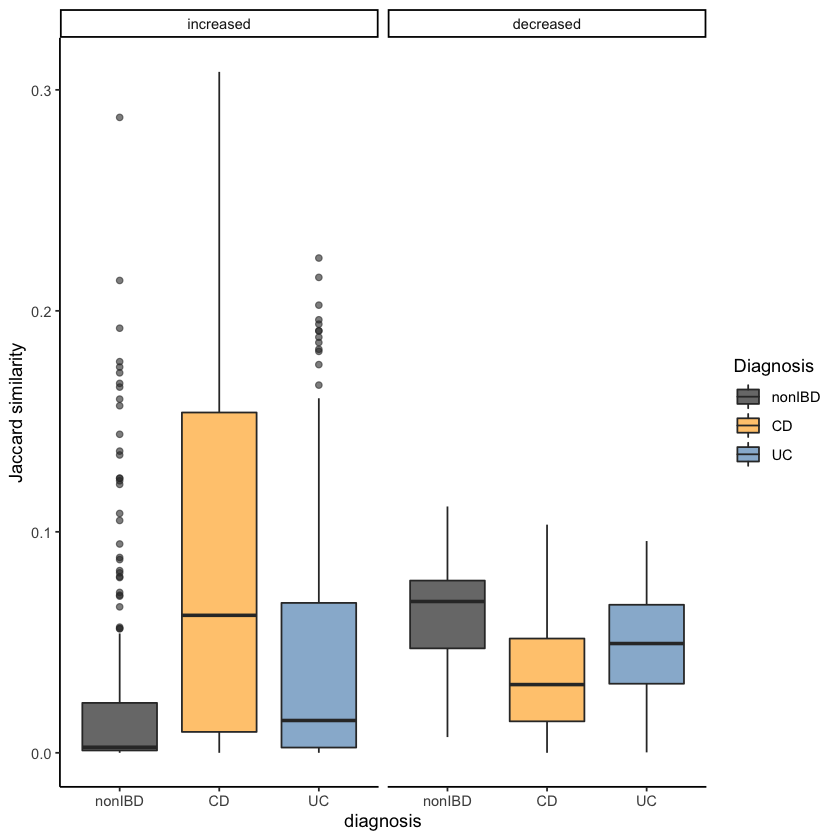

In [14]:
ggplot(all_comp, aes(x = diagnosis, y = jaccard, fill = diagnosis)) +
  geom_boxplot(alpha = .6) + 
  facet_wrap(~abundance) +
  scale_fill_manual(values = c("black", "orange", "steelblue"), name = "Diagnosis") + 
  theme_classic() +
  labs(y = "Jaccard similarity")